# Convolutional Neural Network, CIFAR-10

In this notebook, I will train a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 database. The CIFAR-10 dataset consists of small color images grouped into ten classes, including objects like airplanes, automobiles, birds, cats, and more.

## Project Overview

The process will be broken down into the following steps:
### 1. Load Libraries
   - Importing essential libraries including PyTorch, NumPy, and Matplotlib for data manipulation, machine learning tasks, and visualization.

### 2. Load and Visualize the Data
   - Utilizing PyTorch to download and preprocess the CIFAR-10 dataset.
   - Splitting the dataset into training and testing sets, with a portion allocated for validation.
   - Creating data loaders for efficient loading of batches during training, validation, and testing.

### 3. Visualize a Batch of Training Data
   - Visualizing a batch of training images to gain insights into the nature of the data.
   - Displaying 20 images at a time, each labeled with its respective class.

### 4. View an Image in More Detail
   - Selecting and visualizing a single image in detail by extracting the RGB channels.
   - Creating subplots for each channel and annotating pixel values to understand their contribution to the overall color.

### 5. Define the Network Architecture
   - Defining a CNN architecture named "Net" for image classification.
   - The architecture includes convolutional layers, max-pooling layers, fully connected layers, and dropout layers for regularization.

### 6. Specify Loss Function and Optimizer
   - Loading necessary libraries and specifying categorical cross-entropy as the loss function.
   - Checking for GPU availability and moving the model to GPU if possible.
   - Choosing stochastic gradient descent (SGD) as the optimizer with a learning rate of 0.01.

### 7. Train the Network
   - Training the CNN on the CIFAR-10 dataset for 35 epochs.
   - Monitoring and printing training and validation losses after each epoch.
   - Saving the model state if the validation loss decreases, ensuring the best-performing model is retained.

### 8. Load the Model with the Lowest Validation Loss
   - Loading the model state from the file 'model_cifar.pt,' representing the model with the lowest validation loss.

### 9. Test the Trained Network
   - Evaluating the performance of the trained CNN on the test set.
   - Calculating and printing the average test loss, test accuracy for each class, and overall test accuracy.

### 10. Visualize Sample Test Results
   - Visualizing a batch of test images along with their predicted and true labels.
   - Displaying images in a grid with color-coded titles (green for correct predictions, red for incorrect), providing a quick overview of the model's performance.

----

## Load Libraries

In [19]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Since these are larger (32x32x3) images, it may prove useful to speed up training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [20]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Data Augmentation and Normalization  

First I define data transformations for training and testing images in a machine learning model. For training, the code applies transformations like converting images to tensors, randomly rotating them by 10 degrees, horizontally flipping them, and normalizing the pixel values. These transformations enhance the diversity of the training dataset, helping the model generalize better. The testing (or validation) data undergoes a similar process of conversion to tensors and normalization, but without additional augmentations, ensuring a fair evaluation of the model's performance.

In [21]:
# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.ToTensor(), # Convert data to a tensor
    transforms.RandomRotation(10), # Rotate images by 10 degrees
    transforms.RandomHorizontalFlip(), # Flip images horizontally
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize images
    ])

# Data augmentation and normalization for testing (validation), with augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

## Load Data  

This code sets up data loaders for a machine learning model training process. It specifies parameters such as the number of subprocesses for data loading, batch size (number of images per batch), and the percentage of the training set to be used for validation. Using the CIFAR-10 dataset, it loads both training and testing data, applying the defined transformations to each. The training data is then split into training and validation sets, and random samplers are created to obtain batches for each set. Finally, data loaders are prepared, combining the datasets with their respective samplers, facilitating the training and evaluation of the machine learning model.

In [22]:
# Define parameters for data loaders
num_workers = 0 # Number of subprocesses to use for data loading
batch_size = 20 # Number of samples/images per batch to load
valid_size = 0.2 # Percentage of training set to use as validation

# Load the datasets with ImageFolder 'data'
train_data = datasets.CIFAR10('data', train=True, download=True, transform=train_transform) # set train to True
test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transform) # set train to False

# Obtain training indices that will be used for validation
num_train = len(train_data) # Number of training samples
indices = list(range(num_train)) # List of indices for all training samples
np.random.shuffle(indices) # Shuffle indices to prevent learning order bias
split = int(np.floor(valid_size * num_train)) # Number of training samples to be used for validation (number of indices*20%)
train_idx, valid_idx = indices[split:], indices[:split] # Split indices into training and validation sets

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers) # Use sampler to obtain training batches
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers) # Use sampler to obtain validation batches
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers) # Obtain test batches

Files already downloaded and verified
Files already downloaded and verified


In [23]:
# Specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Visualize a Batch of Training Data  

This code defines a helper function named "imshow" that is used to un-normalize and display an image. The function takes an image as input, un-normalizes it by scaling pixel values, and then uses Matplotlib to display the image. The un-normalization involves dividing the pixel values by 2 and adding 0.5. The function also transposes the image tensor to the format expected by Matplotlib, switching the dimensions to (height, width, channels) from the usual PyTorch tensor format.

In [24]:
# Define helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

 Next I obtain one batch of training images from the training data loader. I use the `iter` function to create an iterator for the `train_loader`, and then the `next` function is called to retrieve a batch of images and their corresponding labels. The images are then converted from PyTorch tensors to NumPy arrays using the `numpy` method for the purpose of display. The final line prints the shape of the array, providing information about the dimensions of the batch, including the number of images, height, width, and channels.

In [25]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
images.shape

(20, 3, 32, 32)

This code creates a plot to display a batch of training images along with their corresponding labels. It uses Matplotlib to generate a figure with a specified size and then iterates through the images in the batch. For each image, a subplot is added to the figure, and the `imshow` function is used to display the image. The title of each subplot is set to the corresponding class label of the image. The resulting plot shows 20 images in a grid, allowing for visual inspection of the training data.

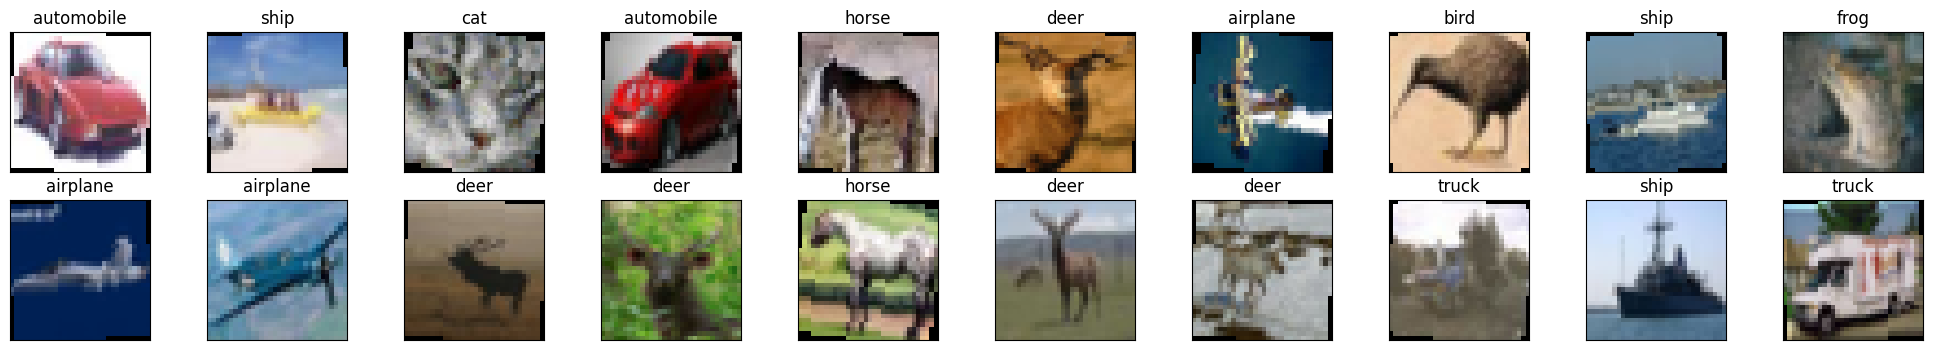

In [26]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

This code selects and visualizes one specific image from the batch by extracting the RGB channels. It starts by squeezing the selected image to remove any single-dimensional entries, making it a 3D array representing the RGB channels. The code then defines the RGB channels and creates a figure with three subplots, one for each channel. Each subplot displays the corresponding channel as a grayscale image. Additionally, it adds annotations to the image, showing the pixel values. The annotation text color is adjusted based on the pixel intensity to ensure visibility. This visualization helps inspect the individual channels of the RGB image and understand how pixel values contribute to the overall color.

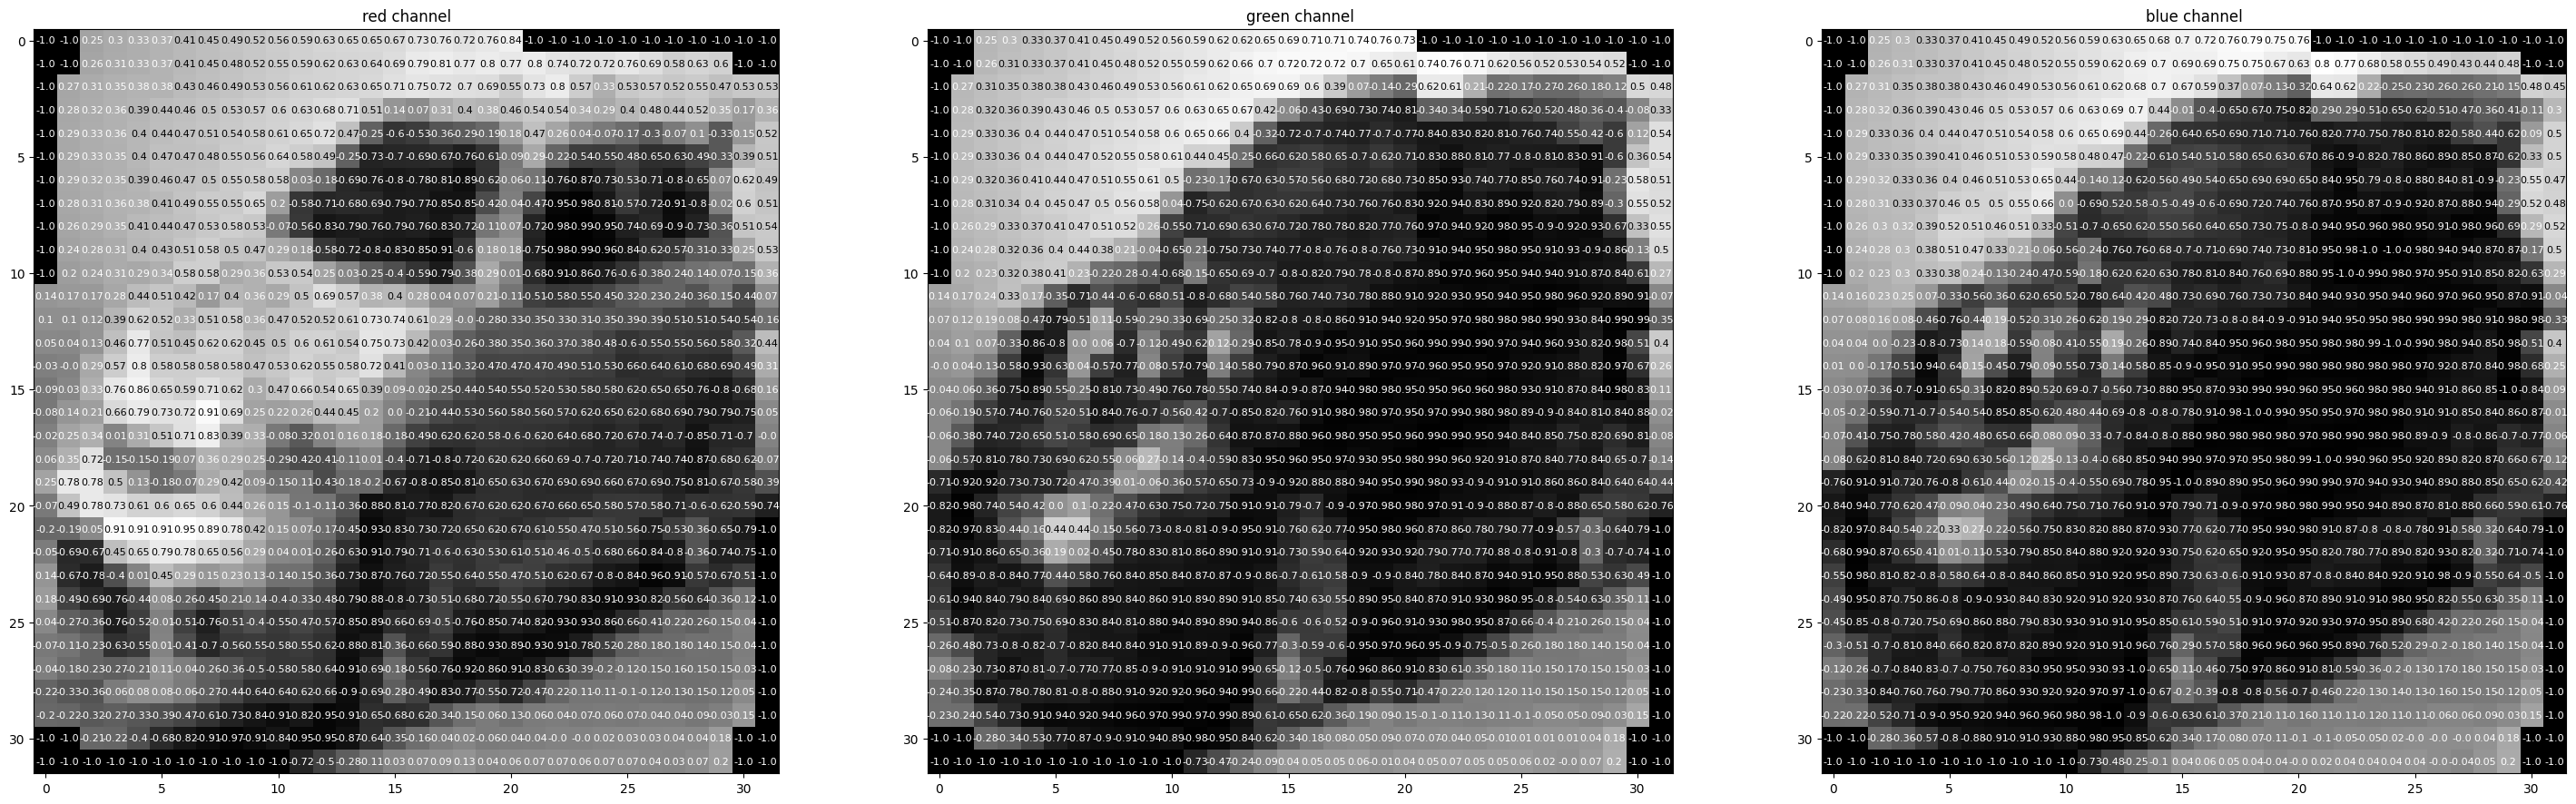

In [27]:
# Select an image from the batch
rgb_img = np.squeeze(images[3]) # Select an image from the batch (index 3) and remove single-dimensional entries from the shape of an array
channels = ['red channel', 'green channel', 'blue channel'] # Define RGB channels

# Plot each channel
fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network 

This code defines a Convolutional Neural Network (CNN) architecture using the PyTorch neural network module (`nn.Module`). The network consists of three convolutional layers (`conv1`, `conv2`, `conv3`) followed by max-pooling layers (`pool`), two fully connected layers (`fc1`, `fc2`), and dropout layers (`dropout`) for regularization.

The convolutional layers are responsible for extracting features from the input image, and max-pooling layers reduce the spatial dimensions. The fully connected layers process the flattened feature vector and produce the final output with 10 classes (assuming a classification task), which is suitable for CIFAR-10 dataset. Dropout layers are included to prevent overfitting during training.

The `forward` method defines the forward pass of the network, specifying how input data is processed through the layers. The architecture is printed, providing a summary of the network's structure. Finally, an instance of the network is created and assigned to the variable `model`.  

*Note:* The code contains formulas in ''' markers ''' to track the precise dimensions of the tensors as they pass through the network.

In [28]:
# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # 3 input channels(RGB), 16 output channels, 3x3 square convolution kernel, by default padding = 0, stride = 1, outputs: 32x32x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16 input channels from conv1 output, 32 output channels, 3x3 square convolution kernel
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 32 input channels from conv2 output, 64 output channels, 3x3 square convolution kernel
        self.pool = nn.MaxPool2d(2, 2) # Max pooling over a (2, 2) window, leads to a reduction in the size of the output image of a factor of 2
        self.fc1 = nn.Linear(64 * 4 * 4, 500) # conv2 outputs 16 channels/depth, with 5x5 image dimensions (after pooling), 120 output channels (fully connected layer
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25) # dropout layer (p=0.25)

    def forward(self, x):
        ###################
        # 1. Conv. Layer  #
        ###################
        x = self.conv1(x) # first convolutional layer turns 32x32x3 image into 28x28x6
        '''
        Input volume size - kernel/filter size + 2*padding              32px - 3 + 2* (padding=1)          31px
        -------------------------------------------------- + 1 = ---------------------------------- + 1  = ------ + 1 =  32px
                            stride                                      (default stride =1)                  1  
        # depth is the number of filters used for the convolutional layerm indicated by second argument in nn.Conv2d for conv1
        '''
        x = F.relu(x)
        x = self.pool(x) # first max pooling layer turns 32x32x16 image into 16x16x16 
        '''
        Input volume size - pooling window size         32px - 2           30px
        --------------------------------------- + 1 = ------------ + 1 = ------ + 1 =  15px + 1 = 16px
                            stride                        2                 2  
        # depth remains unaltered
        '''

        ###################
        # 2. Conv. Layer  #
        ###################
        x = self.conv2(x) # second convolutional layer turns 16x16x16 image into 16x16x32
        '''
        Input volume size - kernel/filter size + 2*padding          16px - 3 + 2* (padding=1)               15 px
        -------------------------------------------------- + 1 = ---------------------------------- + 1  = ------ + 1 =  16px
                            stride                                      (default stride =1)                  1  
        # depth is the number of filters used for the convolutional layerm indicated by second argument in nn.Conv2d for conv2
        '''
        x = F.relu(x)
        x = self.pool(x) # Max pooling layer turns 16x16x32 image into 8x8x32
        '''
        Input volume size - pooling window size         16px - 2           14px
        --------------------------------------- + 1 = ------------ + 1 = ------ + 1 =  7px + 1 = 8px
                            stride                        2                 2  
        # depth remains unaltered
        '''

        ###################
        # 3. Conv. Layer  #
        ###################
        x = self.conv3(x) # third convolutional layer turns 8x8x32 image into 8x8x64
        '''
        Input volume size - kernel/filter size + 2*padding          8px - 3 + 2* (padding=1)               7 px
        -------------------------------------------------- + 1 = ---------------------------------- + 1  = ------ + 1 =  8px
                            stride                                      (default stride =1)                  1  
        # depth is the number of filters used for the convolutional layerm indicated by second argument in nn.Conv2d for conv2
        '''
        x = F.relu(x)
        x = self.pool(x) # Max pooling layer turns 8x8x64 image into 4x4x64
        '''
        Input volume size - pooling window size         8px - 2           6px
        --------------------------------------- + 1 = ------------ + 1 = ------ + 1 =  3px + 1 = 4px
                            stride                        2                 2  
        # depth remains unaltered
        '''

        # At this point image is of size 4x4x64, we flatten it to 1x1024 (4*4*64)
        x = torch.flatten(x, 1) # feature-vector: flatten all dimensions except batch, now we have basically a 1D array of 400 elements
        x = self.dropout(x) # apply dropout to the flattened array
        x = F.relu(self.fc1(x)) # feed it to the fully connected layers, turns 1x1024 into 1x500
        x = self.dropout(x) # apply dropout 
        x = self.fc2(x) # we will later apply softmax to the output of this layer to get the probabilities of each class, hence no activation function is applied here
        return x

# Initialize the NN
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Or in short:

In [29]:
# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# Initialize the NN
model = Net()
print(model)

# Move model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


###  Specify Loss Function and Optimizer

In this code, the necessary libraries for PyTorch are loaded, and then the loss function and optimizer are specified for training the neural network. The loss function is set as categorical cross-entropy, which is commonly used for classification problems. The optimizer chosen is stochastic gradient descent (SGD), and its learning rate is set to 0.01. The optimizer is associated with the parameters of the neural network model (`model.parameters()`), indicating that it will be responsible for updating the weights of the model during the training process to minimize the defined loss. These settings are essential components for configuring and training a neural network for image classification.

In [30]:
import torch.optim as optim

# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Train the Network

This code trains a convolutional neural network (CNN) using the CIFAR-10 dataset for a specified number of epochs (30 in this case). It uses two loops for each epoch, one for training and one for validation. 

In the training loop, the model is set to training mode (`model.train()`), and it iterates through batches of training data. The input data and target labels are moved to the GPU if available, and the forward pass is performed. The loss is calculated using a specified criterion (assumed to be defined elsewhere), and backpropagation is applied to update the model's parameters.

In the validation loop, the model is set to evaluation mode (`model.eval()`), and it iterates through batches of validation data. Similar to the training loop, the forward pass and loss calculation are performed.

The average training and validation losses are printed for each epoch. If the validation loss decreases, the model's state dictionary is saved, representing the model with the best performance on the validation set. The filename for saving the model is 'model_cifar.pt'.

*Note:* Previously I looked at how the training and validation loss decreases over time for a higher number of epochs; if the validation loss ever increases it indicates possible overfitting. Validation loss stoped improving at around 30. Hence, I set n_epochs to 30 for final model.

In [31]:
# Number of epochs to train the model
n_epochs = 35

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(1, n_epochs+1):

    # Monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # Train the model #
    ###################
    model.train()

    for data, target in train_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # Validate the model #
    ######################
    model.eval()

    for data, target in valid_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # Calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.167017 	Validation Loss: 1.925555
Validation loss decreased (inf --> 1.925555).  Saving model ...
Epoch: 2 	Training Loss: 1.760251 	Validation Loss: 1.589790
Validation loss decreased (1.925555 --> 1.589790).  Saving model ...
Epoch: 3 	Training Loss: 1.556177 	Validation Loss: 1.456271
Validation loss decreased (1.589790 --> 1.456271).  Saving model ...
Epoch: 4 	Training Loss: 1.453992 	Validation Loss: 1.360305
Validation loss decreased (1.456271 --> 1.360305).  Saving model ...
Epoch: 5 	Training Loss: 1.367963 	Validation Loss: 1.276331
Validation loss decreased (1.360305 --> 1.276331).  Saving model ...
Epoch: 6 	Training Loss: 1.289197 	Validation Loss: 1.223394
Validation loss decreased (1.276331 --> 1.223394).  Saving model ...
Epoch: 7 	Training Loss: 1.224006 	Validation Loss: 1.151374
Validation loss decreased (1.223394 --> 1.151374).  Saving model ...
Epoch: 8 	Training Loss: 1.165625 	Validation Loss: 1.109784
Validation loss decreased (1.15137

###  Load the Model with the Lowest Validation Loss  

This code snippet loads the previously saved model state (weights and parameters) from the file 'model.pt'. The purpose is to retrieve the trained model that achieved the best validation accuracy during training. By loading this model state, the code ensures that the model used for further evaluation or predictions is the one that demonstrated the highest performance on the validation set during the training process.

In [32]:
# Load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

## Test the Trained Network

This code evaluates the trained convolutional neural network (CNN) on the test dataset. It calculates the test loss and accuracy for each class and provides an overall accuracy.

The model is set to evaluation mode (`model.eval()`), and it iterates through batches of test data. For each batch, the forward pass is performed, and the loss is calculated. The output probabilities are converted to predicted classes, and these predictions are compared to the true labels to determine accuracy. The results are then used to calculate the average test loss and accuracy for each class as well as the overall accuracy.

The printed output includes the test loss, test accuracy for each individual class, and the overall test accuracy across all classes.

In [33]:
# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Prep model for *evaluation*
model.eval()

# Iterate over test data
for data, target in test_loader:
    # Move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    # Forward pass: compute predicted outputs by passing inputs to the model
    output = model.forward(data)
    # Calculate the batch loss
    loss = criterion(output, target)
    # Update test loss 
    test_loss += loss.item()*data.size(0)
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # Compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # Calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Calculate and print avg test accuracy
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Calculate and print overall test accuracy
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.641810

Test Accuracy of airplane: 81% (817/1000)
Test Accuracy of automobile: 85% (853/1000)
Test Accuracy of  bird: 66% (664/1000)
Test Accuracy of   cat: 58% (584/1000)
Test Accuracy of  deer: 77% (775/1000)
Test Accuracy of   dog: 70% (700/1000)
Test Accuracy of  frog: 88% (884/1000)
Test Accuracy of horse: 80% (801/1000)
Test Accuracy of  ship: 86% (869/1000)
Test Accuracy of truck: 86% (860/1000)

Test Accuracy (Overall): 78% (7807/10000)


**Observation**:  
- Weakness of model can be seen in low accuracy on cats class. One remedy could be to include more pictures in training set.

### Visualize Sample Test Results  

This code obtains one batch of test images, runs them through the trained model, and visualizes the predictions alongside the true labels. The model's predictions are compared to the ground truth labels, and the titles of the subplots are color-coded to indicate correct predictions (green) and incorrect predictions (red).

The `imshow` function is used to display the images, and the predicted and true labels are shown in the subplot titles. The color of the title is green if the prediction is correct and red if it is incorrect. This visualization provides a qualitative assessment of how well the trained model performs on a sample of test images. The variable `classes` is assumed to contain the class labels corresponding to the numerical labels in the dataset.

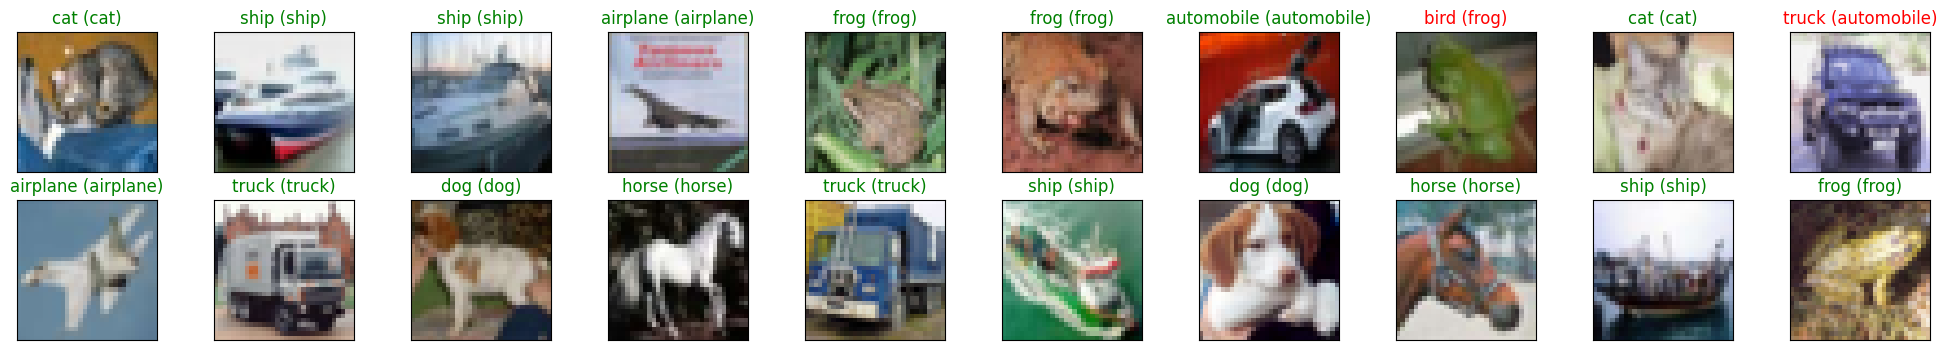

In [34]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# Move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# Get sample outputs
output = model(images)
# Convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))